<a href="https://colab.research.google.com/github/codedec/Project-CustomerChurn-1/blob/main/customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import warnings
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")

In [3]:
# ==== Load Raw Dataset ====
df = pd.read_excel("E Commerce Dataset.xlsx", sheet_name="E Comm")

In [4]:
df.head()


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [6]:
df.shape

(5630, 20)

In [ ]:
df.describe()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,52815.500000,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.223030
std,1625.385339,0.374240,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.207036
min,50001.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,52815.500000,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.280000
75%,54222.750000,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.392500
max,55630.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,324.990000


In [ ]:
# ==== Drop identifier column ====
df = df.drop(columns=["CustomerID"])

In [ ]:
# ==== Replace inconsistent values ====
df["PreferredLoginDevice"] = df["PreferredLoginDevice"].replace("Phone", "Mobile Phone")
df["PreferredPaymentMode"] = df["PreferredPaymentMode"].replace("CC", "Credit Card")
df["PreferredPaymentMode"] = df["PreferredPaymentMode"].replace("COD", "Cash on Delivery")
df["PreferedOrderCat"] = df["PreferedOrderCat"].replace("Mobile", "Mobile Phone")

In [ ]:
# === Separate numerical and categorical columns ====
num_cols = df.select_dtypes(include=["float64", "int64"]).columns.drop("Churn")
cat_cols = df.select_dtypes(include="object").columns

In [ ]:
df.isnull().sum()

,0
Churn,0
Tenure,264
PreferredLoginDevice,0
CityTier,0
WarehouseToHome,251
PreferredPaymentMode,0
Gender,0
HourSpendOnApp,255
NumberOfDeviceRegistered,0
PreferedOrderCat,0


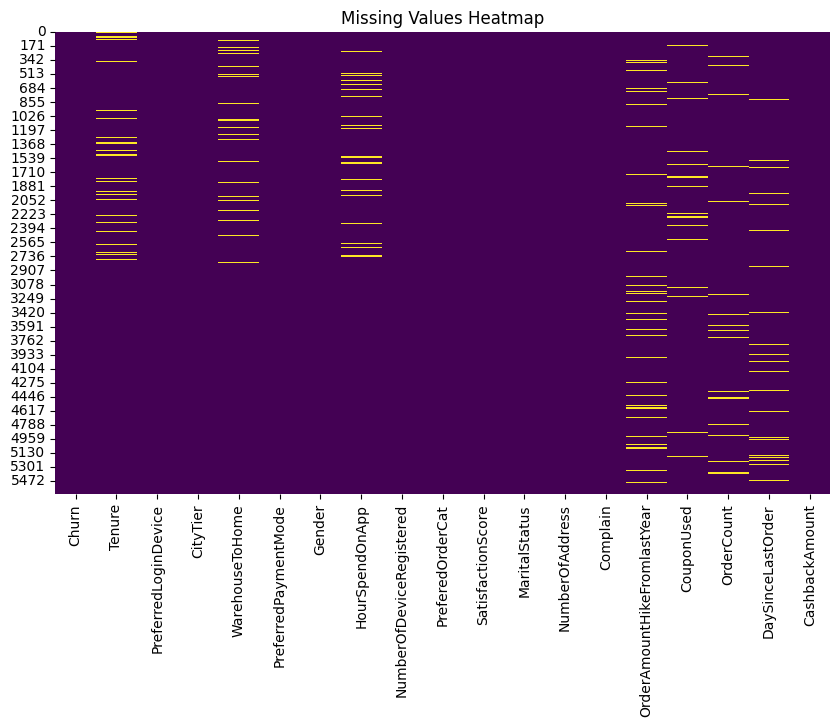

In [ ]:
# === Missing Values Heatmap ===
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


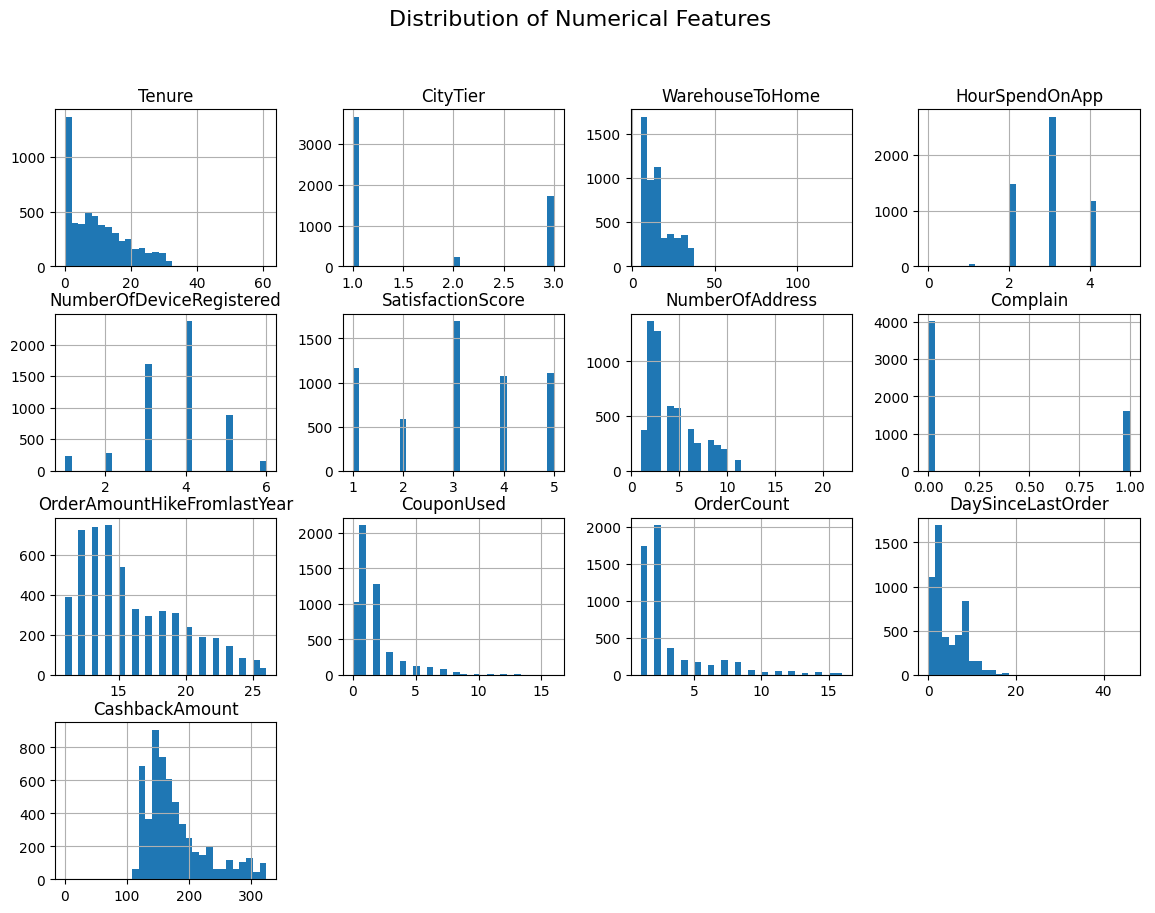

In [ ]:
# === Distribution of Numerical Features ===
df[num_cols].hist(figsize=(14, 10), bins=30)
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()


In [ ]:
# ==== Impute missing numerical values ====
num_imputer = SimpleImputer(strategy="mean")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

In [ ]:
df.isnull().sum()

,0
Churn,0
Tenure,0
PreferredLoginDevice,0
CityTier,0
WarehouseToHome,0
PreferredPaymentMode,0
Gender,0
HourSpendOnApp,0
NumberOfDeviceRegistered,0
PreferedOrderCat,0


# Correlation Method for Numerical variables: Point-Biserial correlation

In [ ]:
# Calculate Point-Biserial correlation
correlations = {}
for col in num_cols:
    if df[col].notna().sum() > 0:
        valid_data = df[['Churn', col]].dropna()
        corr, _ = pointbiserialr(valid_data['Churn'], valid_data[col])
        correlations[col] = corr

In [ ]:
# Convert to DataFrame for heatmap
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation']).sort_values(by='Correlation', ascending=False)


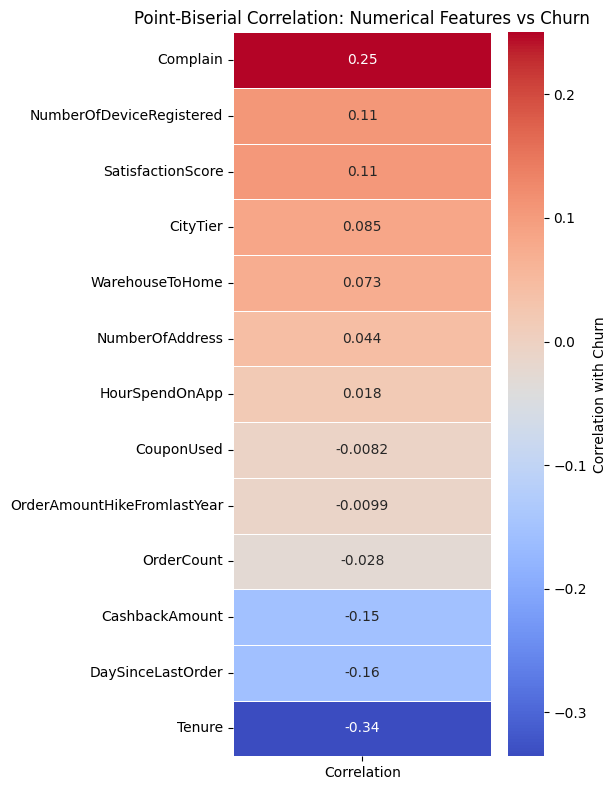

In [ ]:
# Plot heatmap
plt.figure(figsize=(6, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': "Correlation with Churn"})
plt.title("Point-Biserial Correlation: Numerical Features vs Churn")
plt.tight_layout()
plt.show()

# **Insights:**
Tenure has the strongest (negative) correlation with churn → lower tenure → higher churn.

Complain shows a positive correlation → more complaints → higher churn.

DaySinceLastOrder and CashbackAmount also show moderate negative correlation.

# Correlation Method for Categorical variables: Cramér's V

In [ ]:
from scipy.stats import chi2_contingency
import numpy as np

# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Calculate Cramér’s V for each categorical feature with churn
cramers_results = {}
for col in cat_cols:
    if df[col].notna().sum() > 0:
        v = cramers_v(df[col], df['Churn'])
        cramers_results[col] = v

In [ ]:
# Convert to DataFrame
cramers_df = pd.DataFrame.from_dict(cramers_results, orient='index', columns=['CramersV']).sort_values(by='CramersV', ascending=False)


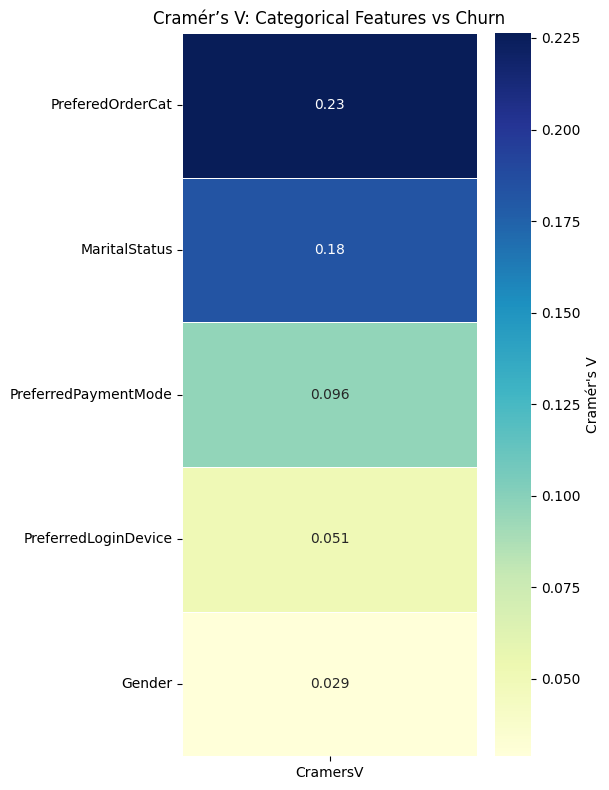

In [ ]:
# Plot heatmap
plt.figure(figsize=(6, 8))
sns.heatmap(cramers_df, annot=True, cmap='YlGnBu', linewidths=0.5, cbar_kws={'label': "Cramér's V"})
plt.title("Cramér’s V: Categorical Features vs Churn")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate churn rate for each category in PreferredOrderCat
churn_by_category = df.groupby('PreferedOrderCat')['Churn'].mean().sort_values(ascending=False)

print(churn_by_category)


PreferedOrderCat
Mobile Phone          0.274038
Fashion               0.154964
Laptop & Accessory    0.102439
Others                0.075758
Grocery               0.048780
Name: Churn, dtype: float64


In [ ]:
# ==== Save cleaned data before encoding ====
os.makedirs("data/cleaned", exist_ok=True)
df.to_excel("data/cleaned/E_Commerce_Cleaned_Before_Encoding.xlsx", index=False)
print("Cleaned dataset (before encoding) saved successfully.")

Cleaned dataset (before encoding) saved successfully.


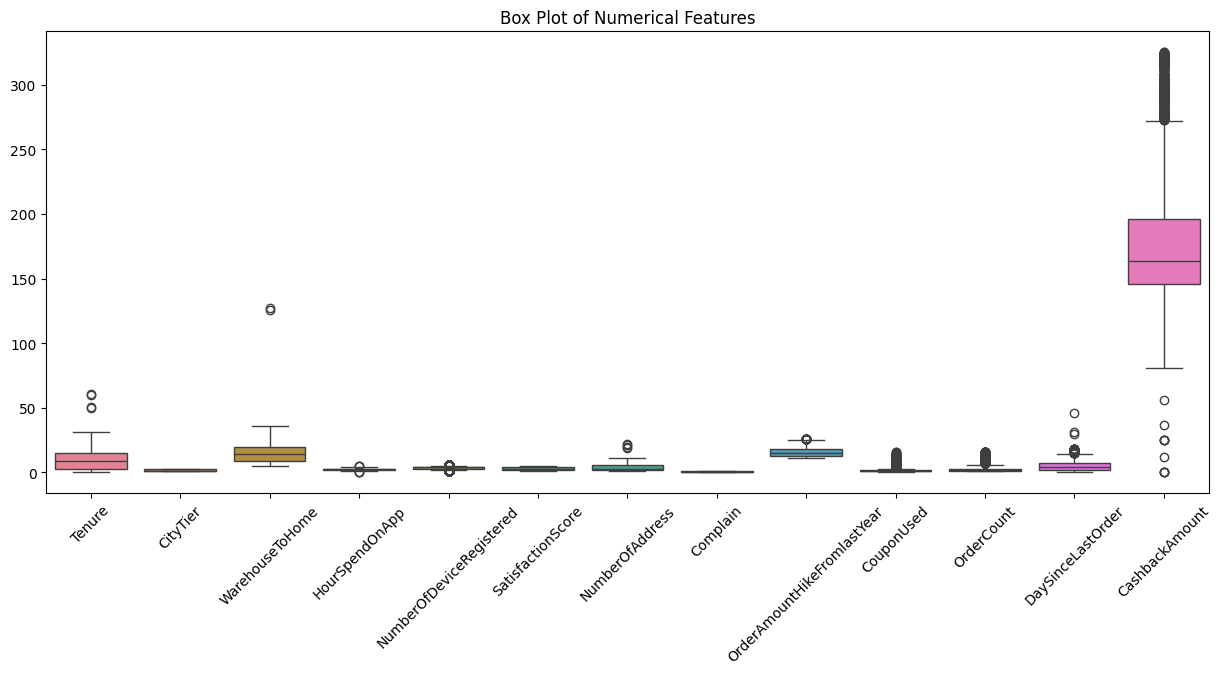

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df[num_cols])
plt.xticks(rotation=45)
plt.title("Box Plot of Numerical Features")
plt.show()


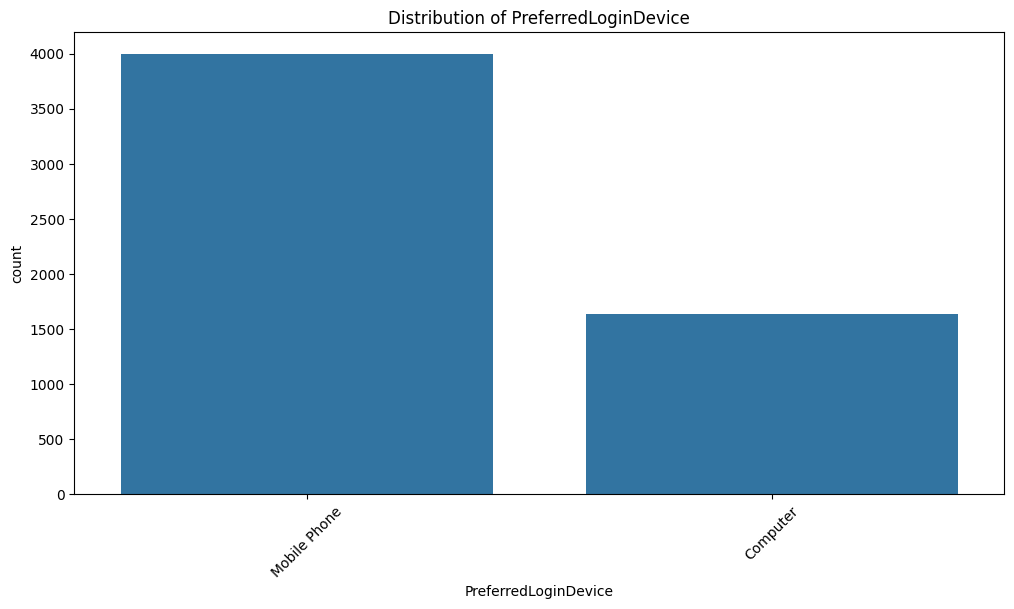

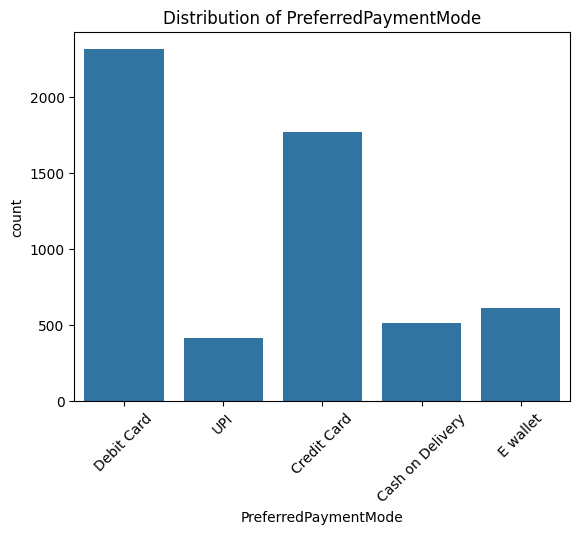

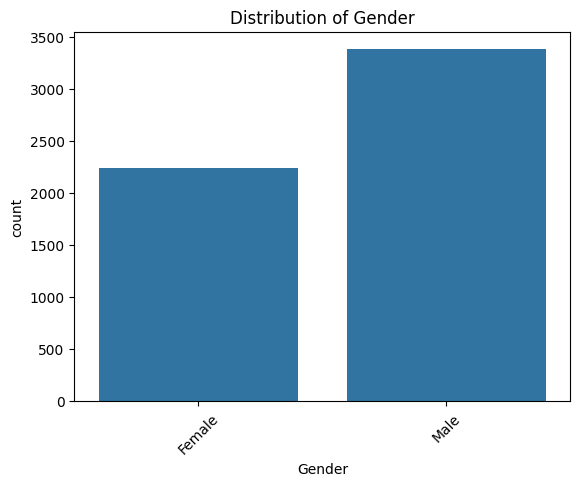

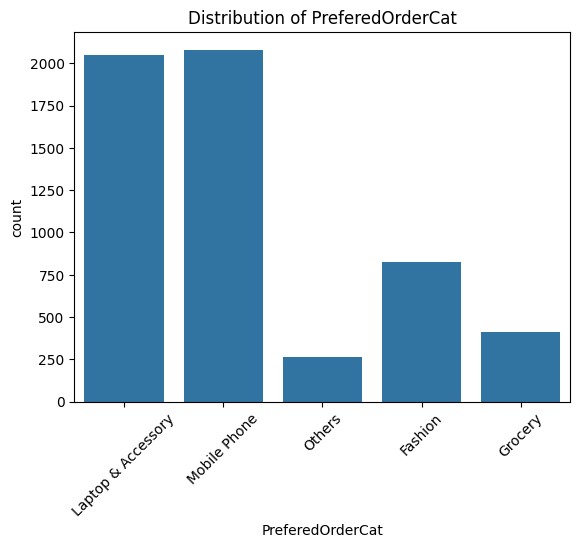

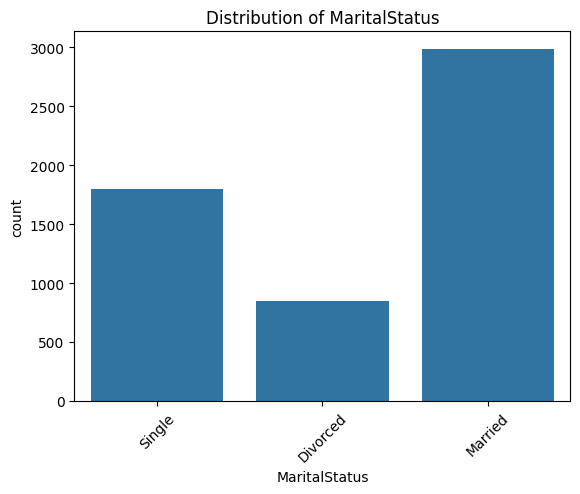

In [ ]:
plt.figure(figsize=(12, 6))
for col in cat_cols:
    sns.countplot(x=df[col])
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
# ==== Encode categorical features using LabelEncoder ====
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
# ==== Separate Features and Target ====
X = df.drop(columns=["Churn"])
y = df["Churn"]

In [ ]:
# check class distribution counts
print(df["Churn"].value_counts())


Churn
0    4682
1     948
Name: count, dtype: int64


In [ ]:
# calculate percentage of each class
print(df["Churn"].value_counts(normalize=True) * 100)


Churn
0    83.161634
1    16.838366
Name: proportion, dtype: float64


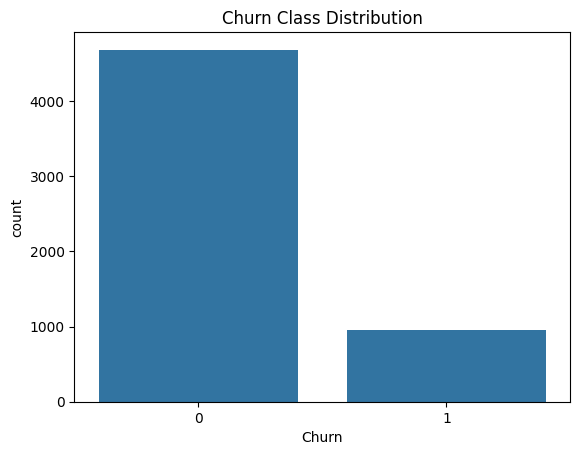

In [ ]:
# visualise class imbalance with a bar plot

sns.countplot(x="Churn", data=df)
plt.title("Churn Class Distribution")
plt.show()


In [ ]:
print(f"Missing values in X before SMOTE: {X.isna().sum().sum()}")

Missing values in X before SMOTE: 0


In [ ]:
#      Handle Imbalanced Data
# ================================
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
print("After SMOTE, training class distribution:")
print(pd.Series(y_resampled).value_counts())


After SMOTE, training class distribution:
Churn
1    4682
0    4682
Name: count, dtype: int64


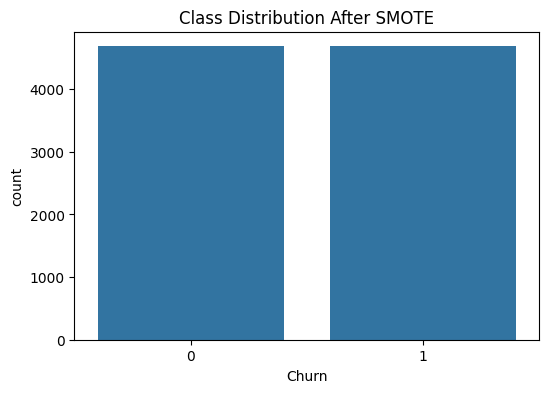

In [ ]:
# Visualize class distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=pd.Series(y_resampled))
plt.title("Class Distribution After SMOTE")
plt.show()

In [ ]:
#    Feature Selection using Random Forest
# =========================================
base_rf = RandomForestClassifier(random_state=42)
base_rf.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [ ]:
# Use median importance as threshold
selector = SelectFromModel(base_rf, threshold="median", prefit=True)
X_selected_all = selector.transform(X_resampled)
selected_all_features = X.columns[selector.get_support()].tolist()

In [ ]:
# === FIX: Do NOT drop any columns after feature selection ===
selected_features = selected_all_features
X_final = X_resampled[selected_features]

print(f"Selected features: {selected_features}")

Selected features: ['Tenure', 'CityTier', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount']


In [ ]:
#       Train/Test Split
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_resampled, test_size=0.2, random_state=42
)

In [ ]:
#     Random Forest Hyperparams (with stronger regularization)
# ================================
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [6, 8, 10],  # Lower max_depth to prevent deep trees
    "min_samples_split": [5, 10, 20],  # Increase min_samples_split
    "min_samples_leaf": [4, 8, 12],    # Increase min_samples_leaf
    "max_features": ["sqrt", "log2"],  # Limit number of features per split
    "class_weight": ["balanced"],
}

In [ ]:
#    Hyperparameter Tuning (RSCV)
# ================================
rf = RandomForestClassifier(random_state=42, bootstrap=True)
random_search = RandomizedSearchCV(
    rf, param_grid, cv=5, scoring="roc_auc", n_iter=10, verbose=2, n_jobs=-1
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': [6, 8, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [4, 8, 12],
                                        'min_samples_split': [5, 10, 20],
                                        'n_estimators': [100, 200]},
                   scoring='roc_auc', verbose=2)

In [ ]:
#     Train Best Random Forest
# ================================
best_rf = RandomForestClassifier(
    **random_search.best_params_,
    max_samples=0.8,
    random_state=42,
    bootstrap=True
)
best_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='log2', max_samples=0.8, min_samples_leaf=8,
                       min_samples_split=5, random_state=42)

In [ ]:
#        Model Evaluation
# ================================
train_score = best_rf.score(X_train, y_train)
test_score = best_rf.score(X_test, y_test)
print(f"Train Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")

Train Accuracy: 0.9470
Test Accuracy: 0.9242


In [ ]:
# ---- Cross-validation ----
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # More robust CV
cv_scores = cross_val_score(
    best_rf,
    X_final[selected_features],
    y_resampled,
    cv=cv,
    scoring="accuracy"
)
print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV Accuracy: 0.9331 ± 0.0062


In [ ]:
# ---- Additional Metrics for Imbalanced Data ----
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
report = classification_report(y_test, y_pred)
print(report)

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")


Confusion Matrix:
[[868  71]
 [ 71 863]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       939
           1       0.92      0.92      0.92       934

    accuracy                           0.92      1873
   macro avg       0.92      0.92      0.92      1873
weighted avg       0.92      0.92      0.92      1873

ROC-AUC Score: 0.9787


In [ ]:
# ==== Ensure model_reports directory exists ====
os.makedirs("model_reports", exist_ok=True)


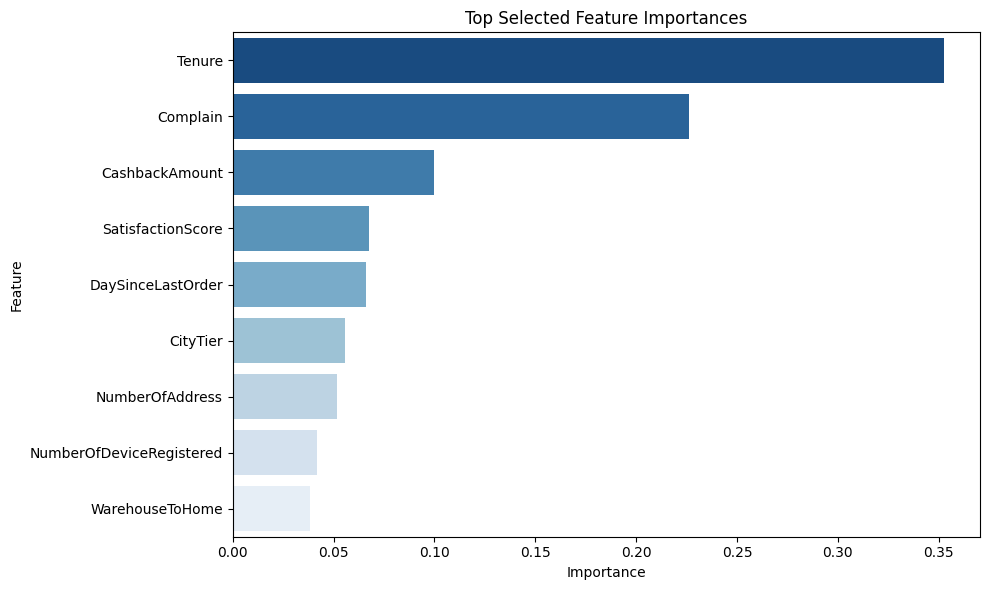

In [ ]:
# ==== Plot and Save Feature Importances ====
importances = best_rf.feature_importances_
feat_imp = pd.Series(importances, index=selected_features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index, palette="Blues_r")
plt.title("Top Selected Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

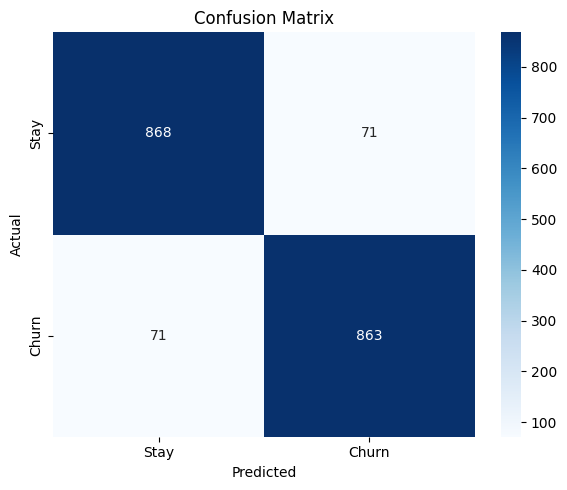

In [ ]:
# ==== Plot and Save Confusion Matrix ====
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Stay", "Churn"], yticklabels=["Stay", "Churn"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

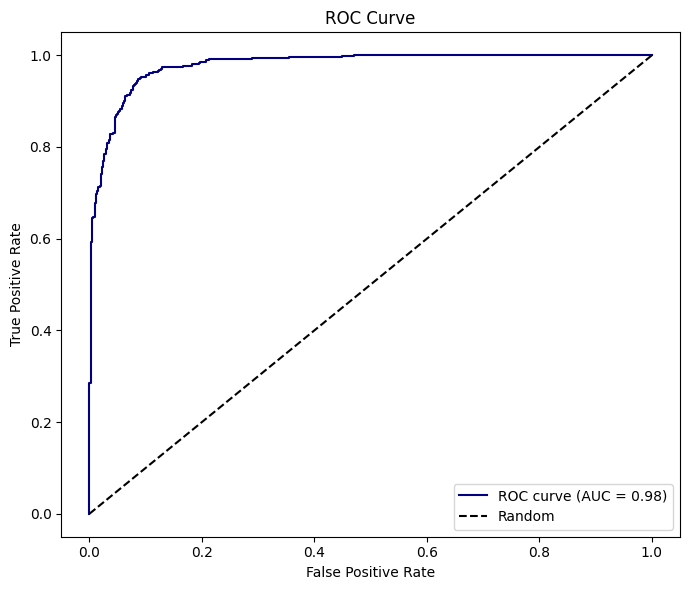

In [ ]:
# ==== Plot and Save ROC Curve ====
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="navy")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:
#        Save Model Bundle
# ================================
model_bundle = {
    "model": best_rf,
    "features": selected_features,
    "label_encoders": label_encoders,
    "num_imputer": num_imputer,
}

joblib.dump(model_bundle, "churn_model_bundle.pkl")
print("Model saved as 'churn_model_bundle.pkl'")

Model saved as 'churn_model_bundle.pkl'
